In [ ]:
#default_exp sio

In [ ]:
#hide_input
import pivotpy as pp 
pp.nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  


# Structure IO

> This includes generating POSCAR form [Materials Project](https://materialsproject.org/). You need their API key to run functions in this module where required.

**Note** : To use materials project data frequently, you may need to save their api key into file. Run function below and it saves key to a file and every function will autoload it.

In [ ]:
#export
import os
import json
import math
import numpy as np
from pathlib import Path
import requests as req
from collections import namedtuple
from itertools import permutations
from itertools import product

from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import pivotpy.vr_parser as vp
import pivotpy.s_plots as sp 

In [ ]:
#hide_input
# To run notebook smoothly, not for module export
from pivotpy.sio import get_bz

In [ ]:
#export
def save_mp_API(api_key):
    """
    - Save materials project api key for autoload in functions.
    """
    home = str(Path.home())
    file = os.path.join(home,'.pivotpyrc')
    lines = []
    if os.path.isfile(file):
        with open(file,'r') as fr:
            lines = fr.readlines()
            lines = [line for line in lines if 'MP_API_KEY' not in line]
        fr.close()
    with open(file,'w') as fw:
        fw.write("MP_API_KEY = {}".format(api_key))
        for line in lines:
            fw.write(line)
        fw.close()

In [ ]:
#export
def load_mp_data(formula,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns fetched data using request api of python form materials project website.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    """
    if api_key is None:
        try:
            home = str(Path.home())
            file = os.path.join(home,'.pivotpyrc')
            with open(file,'r') as f:
                lines=f.readlines()
                for line in lines:
                    if 'MP_API_KEY' in line:
                        api_key = line.split('=')[1].strip()
        except:
            return print("api_key not given. provide in argument or generate in file using `save_mp_API(your_mp_api_key)")
    
    url = "https://www.materialsproject.org/rest/v2/materials/_____/vasp?API_KEY=|||||"
    url = url.replace('_____',formula).replace('|||||',api_key)
    resp = req.request(method='GET',url=url)
    jl = json.loads(resp.text)
    all_res = jl['response']
    if max_sites != None:
        sel_res=[]
        for res in all_res:
            if res['nsites'] <= max_sites:
                sel_res.append(res)
        return sel_res
    # Filter to mp_id at last. more preferred
    if mp_id !=None:
        for res in all_res:
            if mp_id == res['material_id']:
                return [res]
    return all_res

In [ ]:
#export
def get_crystal(formula,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns crystal information dictionary including cif data format.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    """
    all_res = load_mp_data(formula=formula,api_key = api_key, mp_id = mp_id, max_sites = max_sites)
    cifs = []
    for res in all_res:
        cif     = res['cif']
        symbol  = res['spacegroup']['symbol']
        crystal = res['spacegroup']['crystal_system']
        unit    = res['unit_cell_formula']
        mp_id   = res['material_id']
        crs = dict(mp_id = mp_id,symbol = symbol, crystal = crystal, unit = unit, cif = cif)
        cifs.append(vp.Dict2Data(crs))
    return cifs

In [ ]:
#export
def get_poscar(formula ,api_key=None,mp_id=None,max_sites = None):
    """
    - Returns poscar information dictionary including cif data format.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `save_mp_API` function.
        - mp_id    : Optional, you can specify material ID to filter results.
        -max_sites : Option, you can set maximum number of sites to load fastly as it will not fetch all large data sets.
    - **Usage**
        - `get_poscar('GaAs',api_key,**kwargs)`. Same result is returned from `Get-POSCAR` command in PowerShell terminal if Vasp2Visual module is installed.
    """
    crys = get_crystal(formula = formula,api_key = api_key, mp_id = mp_id, max_sites = max_sites)
    poscars = []
    for cr in crys:
        cif = cr.cif
        lines = cif.split('\n')
        if '' in lines.copy():
            lines.remove('')
        abc = []
        abc_ang = []
        index = 0
        for ys in lines:
            if '_cell' in ys:
                if '_length' in ys:
                    abc.append(ys.split()[1])
                if '_angle' in ys:
                    abc_ang.append(ys.split()[1])
                if '_volume' in ys:
                    volume = float(ys.split()[1])
            if '_structural' in ys:
                system = ys.split()[1]
        for i,ys in enumerate(lines):
            if '_atom_site_occupancy' in ys:
                index = i +1 # start collecting pos.
        poses = lines[index:]
        pos_str = ""
        for pos in poses:
            s_p = pos.split()
            pos_str += "{0:>12}  {1:>12}  {2:>12}  {3}\n".format(*s_p[3:6],s_p[0])

        # ======== Cleaning ===========
        abc_ang = [float(ang) for ang in abc_ang]
        abc     = [float(a) for a in abc]
        a = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(1.0,0.0,0.0) # lattic vector a.
        to_rad = 0.017453292519
        gamma = abc_ang[2]*to_rad
        bx,by = abc[1]*np.cos(gamma),abc[1]*np.sin(gamma)
        b = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(bx/abc[0],by/abc[0],0.0) # lattic vector b.
        cz = volume/(abc[0]*by)
        cx = abc[2]*np.cos(abc_ang[1]*to_rad)
        cy = (abc[1]*abc[2]*np.cos(abc_ang[0]*to_rad)-bx*cx)/by
        c = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(cx/abc[0],cy/abc[0],cz/abc[0]) # lattic vector b.
        unit = cr.unit.to_dict()
        elems = [elem for elem in unit.keys()]
        elems = '\t'.join(elems)
        nums  = [str(int(unit[elem])) for elem in unit.keys()]
        nums  = '\t'.join(nums)
        # Get others important info
        symbol  = cr.symbol
        crystal = cr.crystal
        mp_id   = cr.mp_id
        # ======================
        top = system + "\t# [{0}] Generated by PivotPy using Materials Project Database.".format(symbol)
        poscar= "{0}\n  {1}\n {2}\n {3}\n {4}\n  {5}\n  {6}\nDirect\n{7}".format(top,abc[0],a,b,c,elems,nums,pos_str)
        # =======================
        net_out = dict(system = system, symbol = symbol, crystal =crystal,mp_id = mp_id,poscar = poscar)
        poscars.append(vp.Dict2Data(net_out))
    return poscars

In [ ]:
# I alread save key to file, so no need to provide.
pc = get_poscar('GaAs',max_sites=2)
pc[1].__dict__.keys()


dict_keys(['system', 'symbol', 'crystal', 'mp_id', 'poscar'])

In [ ]:
print("material_id: ",pc[1].mp_id)
print("spacegroup symbol: ",pc[1].symbol)
print("\n",pc[1].poscar)

material_id:  mp-2534
spacegroup symbol:  F-43m

 GaAs	# [F-43m] Generated by PivotPy using Materials Project Database.
  4.06599269
     1.0000000000000000     0.0000000000000000     0.0000000000000000
     0.5000000000490150     0.8660254037561398     0.0000000000000000
     0.5000000000490150     0.2886751346042458     0.8164965780265512
  Ga	As
  1	1
Direct
  0.00000000    0.00000000    0.00000000  Ga
  0.75000000    0.75000000    0.75000000  As



In [ ]:
#export
def get_kpath(hsk_list=[],labels=[], n = 5,weight= None ,ibzkpt = None,outfile=None):
    """
    - Generate list of kpoints along high symmetry path. Options are write to file or return KPOINTS list. It generates uniformly spaced point with input `n` as just a scale factor of number of points per unit length. You can also specify custom number of kpoints in an interval by putting number of kpoints as 4th entry in left kpoint.
    - **Parameters**
        - hsk_list : N x 3 list of N high symmetry points, if broken path then [[N x 3],[M x 3],...]. Optionally you can put a 4 values point where 4th entry will decide number of kpoints in current interval. Make sure that points in a connected path patch are at least two i.e. `[[x1,y1,z1],[x2,y2,z2]]` or `[[x1,y1,z1,N],[x2,y2,z2]]`.
        - n        ; int, number per unit length, this makes uniform steps based on distance between points.
        - weight : Float, if None, auto generates weights.
        - gamma  : If True, shifts mesh at gamma point.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - labels : Hight symmetry points labels. Good for keeping record of lables and points indices for later use.                - Note: If you do not want to label a point, label it as 'skip' at its index and it will be removed.
        - outfile: Path/to/file to write kpoints.
    - **Attributes**
        - If `outfile = None`, a tuple is returned which consists of:
            - nkpts   : get_kmesh().nkpts.
            - kpoints : get_kmesh().kpoints.
            - weights : get_kmesh().weights.
    """
    if hsk_list:
        try: hsk_list[0][0][0]
        except: hsk_list = [hsk_list] # Make overall 3 dimensions to include breaks in path
    xs,ys,zs, inds,joinat = [],[],[],[0],[] # 0 in inds list is important
    for j,a in enumerate(hsk_list):
        for i in range(len(a)-1):
            _vec = [_a-_b for _a,_b in zip(a[i][:3],a[i+1] )] # restruct point if 4 entries
            _m = np.rint(np.linalg.norm(_vec)*n).astype(int)

            try: _m = a[i][3] # number of points given explicitly.
            except: pass

            inds.append(inds[-1]+_m)
            if j !=0:

                joinat.append(inds[-2]) # Add previous in joinpath
            xs.append(list(np.linspace(a[i][0],a[i+1][0],_m)))
            ys.append(list(np.linspace(a[i][1],a[i+1][1],_m)))
            zs.append(list(np.linspace(a[i][2],a[i+1][2],_m)))
    xs = [y for z in xs for y in z] #flatten values.
    ys = [y for z in ys for y in z]
    zs = [y for z in zs for y in z]
    if weight == None:
        weight = 1/len(xs)
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in zip(xs,ys,zs)]
    out_str = '\n'.join(out_str)
    N = np.size(xs)
    if ibzkpt != None:
        if os.path.isfile(ibzkpt):
            f = open(ibzkpt,'r')
            lines = f.readlines()
            f.close()
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    if inds:
        inds[-1] = -1 # last index to -1
    # Remove indices and labels where 'skip' appears
    inds = [i for i,l in zip(inds,labels) if 'skip' not in l]
    labels = [l for l in labels if 'skip' not in l]
    top_str = "Automatically generated using PivotPy with HSK-INDS = {}, LABELS = {}, SEG-INDS = {}\n\t{}\nReciprocal Lattice".format(inds,labels,joinat,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        f = open(outfile,'w')
        f.write(out_str)
        f.close()
    else:
        mesh = namedtuple('Mesh',['nkpts','kpoints','weights'])
        return mesh(N,np.array([[x,y,x] for x,y,z in zip(xs,ys,zs)]),[weight for x in xs])

In example below, the overall value of `n = 5` is skipped and 4th entry in the point is used instead. In later example, a 'skipk' label removes high symmetry point index.

In [ ]:
get_kpath([[0.5,0.5,0.5,2],[0,0,0]],n=5,ibzkpt='IBZKPT',labels = ['M','Γ']).kpoints

array([[0.5, 0.5, 0.5],
       [0. , 0. , 0. ]])

In [ ]:
get_kpath([[[0.375,0.375,0.5,21],[0,0,0]],[[0.5,0.25,0.5],[0,0,0]],[[0.25,0.25,0.25],[0,0,0]]],n=11,labels = ['M','skip','Γ|M','L'],outfile='kpt.txt')

```shell
Automatically generated using PivotPy with HSK-INDS = [0, 29, -1], LABELS = ['M', 'Γ|M', 'L'], SEG-INDS = [21, 29]
	34
```
`HSK-INDS = [0, 29, -1]` should be `[0,21,29,-1]` but `skip` label removed it. Also after 21, it may have 32 as n=11, but distance smaller than 1 resulted in only 8 points there. This is pretty useful if you don't need to rescale kpoint axis later on based on distance.

In [ ]:
#export
def get_basis(poscar=None):
    """Returns poscar(real space basis vectors) and basis in form of namedtuple. 
    - **Parameters**
        - poscar: path/to/POSCAR or 3 given vectors as rows of a mtrix."""
    if isinstance(poscar,type(None)) and os.path.isfile('./POSCAR'):
        poscar = './POSCAR'
    elif isinstance(poscar,str) and not os.path.isfile(poscar):
        raise ValueError("Argument 'poscar' expects path to 'POSCAR' or 3 basis vectors.")
    
    a1,a2,a3=[],[],[]
    if np.ndim(poscar) ==2:
        a1, a2, a3 = poscar[0],poscar[1],poscar[2]
    elif os.path.isfile(poscar):
        a1, a2, a3 = vp.islice2array(poscar,start=2,nlines=3).reshape((-1,3))
    else:
        raise FileNotFoundError("{!r} does not exist or not 3 by 3 list.".format(poscar))
    # Process
    V  = np.dot(a1,np.cross(a2,a3))
    b1 = np.cross(a2,a3)/V
    b2 = np.cross(a3,a1)/V
    b3 = np.cross(a1,a2)/V
    Basis = namedtuple('Basis', ['poscar', 'basis'])
    return Basis(np.array([a1,a2,a3]),np.array([b1,b2,b3]))

In [ ]:
get_basis([[ 4.00771850e+00,  0.00000000e+00, -0.00000000e+00],
       [ 2.00385925e+00,  3.47078603e+00,  5.06700000e-13],
       [ 2.00385925e+00,  1.15692868e+00,  3.27228845e+00]])

Basis(poscar=array([[ 4.00771850e+00,  0.00000000e+00, -0.00000000e+00],
       [ 2.00385925e+00,  3.47078603e+00,  5.06700000e-13],
       [ 2.00385925e+00,  1.15692868e+00,  3.27228845e+00]]), basis=array([[ 2.49518523e-01, -1.44059586e-01, -1.01865510e-01],
       [-0.00000000e+00,  2.88119173e-01, -1.01865511e-01],
       [ 0.00000000e+00, -4.46140330e-14,  3.05596531e-01]]))

## KPOINTS Mesh for Fermi Surface Calculations
- The command `get_kmesh` generates a uniform grid in first (primitive) Brillouin zone.
- The POSCAR is used to get ratios of side lengths in first BZ. Use relaxed and same POSCAR you will use in actual calculations. If you use Vasp's auto generated mesh, use ISYM = -1 to list all points and points inside BZ will be filtered later on while plotting Fermi Surface.
- KPOINTS are written on `outfile` provided, if `outfile = None`, thn BZ data object is returned. 
- IBZKPT file path could be given to argument `ibzkpt` to include it automatically, this is important to include for HSE calculations with `weight = 0`. If `weight = None`, weights are distributed uniformly.
- If you provide `n_xyz = integer`,(recommended for auto uniform mesh), all sides have same number of points unless you provide `poscar` too, in that case `n_xyz` is chosen for smallest side in reciprocal space and other sides are scaled based on their lengths according to given POSCAR. 

In [ ]:
#export
def get_kmesh(n_xyz=[5,5,5],weight = None, ibzkpt= None,poscar=None,outfile=None):
    """
    - Generates uniform mesh of kpoints. Options are write to file, or return KPOINTS list.
    - **Parameters**
        - n_xyz  : List of [nx ny nz] or integer. If integer given, it represents numbers of kpoints along smallest side in reciprocal space and kmesh is autoscaled.
        - weight : Float, if None, auto generates weights.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - poscar : POSCAR file or real space lattice vectors, if None, cubic symmetry is used and it is fast.
        - outfile: Path/to/file to write kpoints.
    - **Attributes**
        - If `outfile = None`, a tuple is returned which consists of:
            - nkpts   : get_kmesh().nkpts.
            - kpoints : get_kmesh().kpoints.
            - weight  : get_kmesh().weight, its one float number, provided or calculated.
    """
    if type(n_xyz) == int:
        nx,ny,nz = n_xyz,n_xyz,n_xyz
    else:
        nx,ny,nz = [n for n in n_xyz]
    
    if poscar and type(n_xyz) == int:
        Basis = get_basis(poscar)
        weights = np.linalg.norm(Basis.basis,axis=1)
        weights = weights/np.min(weights) # For making smallest side at given n_xyz
        nx, ny, nz = np.rint(weights*n_xyz).astype(int)

    points = []
    for k in np.linspace(0,1,nz):
        for j in np.linspace(0,1,ny):
            for i in np.linspace(0,1,nx):
                points.append([i,j,k])
    points = np.array(points)
    points[np.abs(points) < 1e-10] = 0
    top_info=''

    if len(points) == 0:
        return print('No KPOINTS in BZ from given input. Try larger input!')
    if weight == None and len(points) != 0:
        weight = float(1/len(points))
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in points]
    out_str = '\n'.join(out_str)
    N = len(points)
    if ibzkpt != None:
        if os.path.isfile(ibzkpt):
            f = open(ibzkpt,'r')
            lines = f.readlines()
            f.close()
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    top_str = "Automatically generated uniform mesh using PivotPy with {}x{}x{} grid{}\n\t{}\nReciprocal Lattice".format(nx,ny,nz,top_info,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        f = open(outfile,'w')
        f.write(out_str)
        f.close()
    else:
        mesh = namedtuple('Mesh',['nkpts','kpoints','weight'])
        return mesh(N,points,weight)

In [ ]:
get_kmesh(n_xyz=[3,3,3],poscar=[[1,1,0],[0,1,1],[1,0,0.5]]).nkpts

27

In [ ]:
#export
def tan_inv(vy,vx):
    """
    - Returns full angle from x-axis counter clockwise.
    - **Parameters**
        - vy : Perpendicular componet of vector including sign.
        - vx : Base compoent of vector including sign.
    """
    angle = 0  # Place hodler to handle exceptions
    if vx == 0 and vy == 0:
        angle = 0
    elif vx == 0 and np.sign(vy) == -1:
        angle = 3*np.pi/2
    elif vx == 0 and np.sign(vy) == 1:
        angle = np.pi/2
    else:
        theta = abs(np.arctan(vy/vx))
        if np.sign(vx) == 1 and np.sign(vy) == 1:
            angle = theta
        if np.sign(vx) == -1 and np.sign(vy) == 1:
            angle = np.pi - theta
        if np.sign(vx) == -1 and np.sign(vy) == -1:
            angle = np.pi + theta
        if np.sign(vx) == 1 and np.sign(vy) == -1:
            angle = 2*np.pi - theta
        if np.sign(vx) == -1 and vy == 0:
            angle = np.pi
        if np.sign(vx) == 1 and vy == 0:
            angle = 2*np.pi
    return angle

def order(points,loop=True):
    """
    - Returns indices of counterclockwise ordered vertices of a plane in 3D.
    - **Parameters**
        - points: numpy array of shape (N,3) or List[List(len=3)]. 
        - loop  : Default is True and appends start point at end to make a loop. 
    - **Example**
        > pts = np.array([[1,0,3],[0,0,0],[0,1,2]])       
        > inds = order(pts)        
        > pts[inds]        
        ```
        array([[1, 2, 3],
               [0, 0, 0],
               [1, 0, 3]
               [0, 1, 2]])
        ```
    """
    points = np.array(points) # Make array. 
    # Fix points if start point is zero. 
    if np.sum(points[0]) == 0:
        points = points + 0.5 

    center = np.mean(points,axis=0) # 3D cent point. 
    vectors = points - center # Relative to center
    
    ex = vectors[0]/np.linalg.norm(vectors[0])  # i
    ey = np.cross(center,ex)
    ey = ey/np.linalg.norm(ey)  # j

    angles= []
    for i, v in enumerate(vectors):
        vx = np.dot(v,ex)
        vy = np.dot(v,ey)
        angle = tan_inv(vy,vx)
        angles.append([i,angle])
    
    s_angs = np.array(angles)
    ss = s_angs[s_angs[:,1].argsort()] #Sort it. 

    if loop: # Add first at end for completing loop. 
        ss = np.concatenate((ss,[ss[0]]))

    return ss[:,0].astype(int) # Order indices. 


def out_bz_plane(test_point,plane):
    """
    - Returns True if test_point is between plane and origin. Could be used to sample BZ mesh in place of ConvexHull.
    - **Parameters**
        - test_points: 3D point.
        - plane      : List of at least three coplanar 3D points.
    """
    outside = True
    p_test = np.array(test_point)
    plane = np.unique(plane,axis=0) #Avoid looped shape. 
    c = np.mean(plane,axis=0) #center
    _dot_ = np.dot(p_test-c,c)
    if _dot_ < -1e-5:
        outside = False
    return outside


def rad_angle(v1,v2):
    """
    - Returns interier angle between two vectors.
    - **Parameters**
        - v1,v2 : Two vectors/points in 3D.
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    norm  = np.linalg.norm(v1)*np.linalg.norm(v2)
    dot_p = np.round(np.dot(v1,v2)/norm,12)
    angle = np.arccos(dot_p)
    return angle


In [ ]:
import numpy as np
print("Interier Angle:",rad_angle([0,0.1,0],[0,0.5,1]))
print("Angle with x-axis:",tan_inv(1,0))
pts = np.array([[1,0,3],[0,0,0],[0,1,2]])
inds = order(pts)
pts[inds]

Interier Angle: 1.1071487177940433
Angle with x-axis: 1.5707963267948966


array([[0, 1, 2],
       [0, 0, 0],
       [1, 0, 3],
       [0, 1, 2]])

In [ ]:
#export
def get_bz(poscar = None,loop = True,digits=8,primitive=False):
    """
    - Return required information to construct first Brillouin zone in form of tuple (basis, normals, vertices, faces).
    - **Parameters**
        - poscar : POSCAR file or list of 3 vectors in 3D aslist[list,list,list].
        - loop   : If True, joins the last vertex of a BZ plane to starting vertex in order to complete loop.
        - digits : int, rounding off decimal places, no effect on intermediate calculations, just for pretty final results.
        - primitive: Defualt is False and returns Wigner-Seitz cell, If True returns parallelipiped in rec_basis. 
    - **Attributes**
        - basis   : get_bz().basis, recprocal lattice basis.
        - normals : get_bz().normals, all vertors that are perpendicular BZ faces/planes.
        - vertices: get_bz().vertices, all vertices of BZ, could be input into ConvexHull for constructing 3D BZ.
        - faces   : get_bz().faces, vertices arranged into faces, could be input to Poly3DCollection of matplotlib for creating BZ from faces' patches.
        - specials : get_bz().specials, Data with attributes `coords` and `kpoints` in on-one correspondence for high symmetry KPOINTS in recirprocal coordinates space.
    """
    Basis = get_basis(poscar) # Reads 
    b1, b2, b3 = Basis.basis # basis are reciprocal basis
    #s_f= np.sqrt(np.dot(b1,b1)) # Do not scale to 1, it makes difficult to compare to lattices
    #b1,b2,b3 = b1/s_f,b2/s_f,b3/s_f # Normalize vectors
    basis = np.array([b1,b2,b3])
    # Get all vectors for BZ
    if primitive:
        b0 = np.array([0,0,0])
        bd = b1+b2+b3 #Diagonal point
        faces = np.array([
                 [b0, b1, b1+b2, b2],
                 [b0,b2,b2+b3,b3],
                 [b0,b3,b3+b1,b1],
                 [b1,b1+b2,b1+b3,bd],
                 [b2,b2+b1,b2+b3,bd],
                 [b3,b3+b1,b3+b2,bd]
                ])
    else:
        vectors = []
        for i,j,k in product([0,1,-1],[0,1,-1],[0,1,-1]):
            vectors.append(i*b1+j*b2+k*b3)
        vectors = np.array(vectors)
        # Generate voronoi diagram
        vor = Voronoi(vectors)
        faces = []
        vrd = vor.ridge_dict
        for r in vrd:
            if r[0] == 0 or r[1] == 0:
                verts_in_face = np.array([vor.vertices[i] for i in vrd[r]])
                faces.append(verts_in_face)
        #faces = np.array(faces) # should be a list instead as not regular shape. 

    verts = [v for vs in faces for v in vs]
    verts = np.unique(verts,axis=0)

    face_vectors = []
    for f in faces:
        face_vectors.append(2*np.mean(f,axis=0))

    # Order Faces. 
    faces = [face[order(face,loop=loop)] for face in faces] # order based on given value of loop 

    # High symmerty KPOINTS in primitive BZ (positive only)
    mid_faces = np.array([np.mean(np.unique(face,axis=0),axis=0) for face in faces])
    mid_edges = []
    for f in faces:
        for i in range(len(f)-1):
            # Do not insert point between unique vertices
            if np.isclose(np.linalg.norm(f[i]),np.linalg.norm(f[i+1])):
                mid_edges.append(np.mean([f[i],f[i+1]],axis=0))
    if mid_edges!=[]:
        mid_edges = np.unique(mid_edges,axis=0) # because faces share edges
        mid_faces = np.concatenate([mid_faces,mid_edges])
    # Bring all high symmetry points together.
    mid_all = np.concatenate([[[0,0,0]],mid_faces,verts]) # Coords
    mid_basis_all = np.array([np.linalg.solve(basis.T,v) for v in mid_all]) # Kpoints

    # Round off results
    mid_all_p    = np.round(mid_all,digits) # Coordinates
    mid_basis_p  = np.round(mid_basis_all,digits) # Relative points
    bais         = np.round(basis,digits)
    face_vectors = np.round(face_vectors,digits)
    verts        = np.round(verts,digits)
    faces        = tuple([np.round(face,digits) for face in faces])
    one_to_one   = vp.Dict2Data({'coords': mid_all_p ,'kpoints': mid_basis_p})
    #one_to_one   = {tuple(x):tuple(y) for x,y in zip(mid_basis_p,mid_all_p)}
    BZ = namedtuple('BZ', ['basis', 'normals','vertices','faces','specials'])
    return BZ(basis,face_vectors,verts,faces,one_to_one)

In [ ]:
import numpy as np
bbya = 1.2
cbya = 0.8
ofco = [[1,bbya,0],[-1,bbya,0],[0,0,cbya]]
bco = [[1,bbya,cbya],[-1,bbya,cbya],[-1,-bbya,cbya]]
fco = [[1,0,cbya],[1,bbya,0],[0,bbya,cbya]]
bcc = [[1,1,1],[-1,1,1],[-1,-1,1]]
cube = [[1,0,0],[0,1,0],[0,0,1]]
hexa = [[1,0,0],[0.5,np.sqrt(3)/2,0],[0,0,1]]

ctg = [[1,1,cbya],[1,-1,cbya],[-1,-1,cbya]]
tgl = [[0.81915,-0.472937,0.94923],[0,0.94587,0.94923],[-0.81915,-0.472937,0.94923]]
fcc =[[0.0000000000000000,    0.5020149905223673,    0.5020149905223673],
    [0.5020149905223673,    0.0000000000000000,    0.5020149905223673],
     [0.5020149905223673,    0.5020149905223673,    0.0000000000000000]]

basis,normals,vertices,faces,specials = get_bz(fcc,digits=4)
print(basis)
for k,v in zip(specials.coords[:10],specials.kpoints[:10]):
    print(v,'-->',k)

[[-0.99598619  0.99598619  0.99598619]
 [ 0.99598619 -0.99598619  0.99598619]
 [ 0.99598619  0.99598619 -0.99598619]]
[-0.  0.  0.] --> [0. 0. 0.]
[ 0.5 -0.   0.5] --> [ 0.     0.996 -0.   ]
[0.5 0.  0. ] --> [-0.498  0.498  0.498]
[0.5 0.5 0. ] --> [ 0.    -0.     0.996]
[-0.   0.5  0.5] --> [ 0.996 -0.    -0.   ]
[0.5 0.5 0.5] --> [0.498 0.498 0.498]
[-0.  -0.5  0. ] --> [-0.498  0.498 -0.498]
[-0.   0.   0.5] --> [ 0.498  0.498 -0.498]
[-0.5  0.  -0.5] --> [ 0.    -0.996  0.   ]
[-0.5 -0.5 -0.5] --> [-0.498 -0.498 -0.498]


In [ ]:
#export
def splot_bz(poscar_or_bz = None, ax = None, plane=None,color='blue',fill=True,vectors=True,v3=False,vname='b'):
    """
    - Plots matplotlib's static figure.
    - **Parameters**
        - pocar_or_bz: POSCAR or 3 basis vectors' list forming POSCAR. Auto picks in working directory. Plot conventional BZ if poscar is given. If you want to plot primitive BZ, first create it using `get_bz(primitive=True)`.
        - fill       : True by defult, determines whether to fill surface of BZ or not.
        - color      : color to fill surface and stroke color.
        - vectors    : Plots basis vectors, default is True.
        - v3         : Plots 3rd vector as well. Only works in 2D and when `vectors=True`. 
        - plane      : Default is None and plots 3D surface. Can take 'xy','yz','zx' to plot in 2D. 
        - ax         : Auto generated by default, 2D/3D axes, auto converts in 3D on demand as well.
        - vname      : Default is `b` for reciprocal space, can set `a` for plotting cell as after `get_bz(get_bz().basis)` you get real space lattice back if `primitive=True` both times. 
    - **Returns**
        - ax   : Matplotlib's 2D axes if `plane=None`.
        - ax3d : Matplotlib's 2D axes if `plane` is given. 
    """
    if poscar_or_bz == None:
        bz = get_bz(poscar_or_bz)
    else:
        try:
            poscar_or_bz.basis
            bz = poscar_or_bz
        except AttributeError:
            bz = get_bz(poscar_or_bz)

    if not ax: #For both 3D and 2D, initialize 2D axis. 
        ax = sp.init_figure(figsize=(3.4,3.4)) #For better display

    _label = r'\vec{}'.format(vname) # For both

    valid_planes = 'xyzx' # cylic
    if plane and plane not in valid_planes:
        return print(f"`plane` expects any of ['xy','yz','zx',None], got {plane!r}")
    elif plane and plane in valid_planes: #Project 2D
        faces = bz.faces
        i, j = ([0,1] if plane=='xy' else [1,2] if plane=='yz' else [2,0])
        _ = [ax.plot(f[:,i],f[:,j],color=(color),lw=1) for f in faces]

        if vectors:
            if v3:
                s_basis = bz.basis 
            else:
                s_basis = bz.basis[[i,j]] # Only two. 
            for k,y in enumerate(s_basis):
                label = "\n" + r" ${}_{}$".format(_label,k+1)
                ax.text(0.8*y[i],0.8*y[j], label, va='center',ha='left')
                ax.plot([0,y[i]],[0,y[j]],color='k',lw=0.8) # Must be to scale below arrow. 
                ax.arrow(0,0,y[i],y[j],lw=0.8,capstyle='butt',head_width=0.03,color='k')
        
        ax.set_xlabel(r"$k_{}$".format(valid_planes[i]))
        ax.set_ylabel(r"$k_{}$".format(valid_planes[j]))
        ax.set_aspect(1) # Must for 2D axes to show actual lengths of BZ
        return ax 
    else: # Plot 3D
        if ax and ax.name == "3d":
            ax3d = ax 
        else:
            pos = ax.get_position()
            fig = ax.get_figure()
            ax.remove()
            ax3d = fig.add_axes(pos,projection='3d',azim=45,elev=30)

        if fill:
            poly = Poly3DCollection(bz.faces,edgecolors=[color,],facecolors=[color,], alpha=0.3)
            ax3d.add_collection3d(poly)
            ax3d.autoscale_view()
        else:
            _ = [ax3d.plot3D(f[:,0],f[:,1],f[:,2],color=(color),lw=0.8) for f in bz.faces]
        
        if vectors:
            orig, sv = [0,0,0],0.25*bz.basis
            ax3d.quiver(orig,orig,orig,sv[:,0],sv[:,1],sv[:,2], normalize=False,lw=0.8,color='k',arrow_length_ratio=0.25)

            for k,y in enumerate(0.35*bz.basis):
                ax3d.text(y[0],y[1],y[2],r"${}_{}$".format(_label,k+1),va='center',ha='center')
        

        l_ = np.min(bz.vertices,axis=0)
        h_ = np.max(bz.vertices,axis=0)
        ax3d.set_xlim([l_[0],h_[0]])
        ax3d.set_ylim([l_[1],h_[1]])
        ax3d.set_zlim([l_[2],h_[2]])

        ax3d.set_xlabel(r"$k_{}$".format('x'))
        ax3d.set_ylabel(r"$k_{}$".format('y'))
        ax3d.set_zlabel(r"$k_{}$".format('z'))
        return ax3d



In [ ]:
import pivotpy.s_plots as sp
lat = hexa
bz = get_bz(lat,primitive=False,loop=True)
axs = sp.init_figure(ncols=4,figsize=(9,2))
ax2d = splot_bz(bz,plane='xy',ax=axs[0],vectors=True,color=(0.7,0,0.5))
ax3d = splot_bz(bz,ax=axs[1],color=(108/255,204/255,215/255),vectors=True)
prim_bz = get_bz(lat,primitive=True)
ax3d_ = splot_bz(prim_bz,ax=axs[2],color=(212/255,175/255,55/255),vectors=True)
_ax3d = splot_bz(get_bz(prim_bz.basis,primitive=True),ax=axs[3],color=(212/255,175/255,55/255),vectors=True,vname='a')
ax3d.set_axis_off()
ax3d.set_title('Regular BZ')
ax3d_.set_axis_off()
ax3d_.set_title('Primitive BZ')
ax2d.set_axis_off()
_ax3d.set_title('Real lattice')
_ax3d.set_axis_off()
ax2d.set_title('XY Projection of Regular BZ')
sp.plt_to_html()

<Figure size 648x144 with 0 Axes>

In [ ]:
#export
def iplot_bz(poscar_or_bz = None,fill = True,color = 'rgba(168,204,216,0.4)',
                        background = 'rgb(255,255,255)',vname = 'b', fig=None):
    """
    - Plots interactive figure showing axes,BZ surface, special points and basis, each of which could be hidden or shown.
    - **Parameters**
        - pocar_or_bz: POSCAR or 3 basis vectors' list forming POSCAR. Auto picks in working directory. Plot conventional BZ if poscar is given. If you want to plot primitive BZ, first create it using `get_bz(primitive=True)`.
        - fill       : True by defult, determines whether to fill surface of BZ or not.
        - color      : color to fill surface 'rgba(168,204,216,0.4)` by default.
        - background : Plot background color, default is 'rgb(255,255,255)'.
        - vname      : Default is `b` for reciprocal space, can set `a` for plotting cell as after `get_bz(get_bz().basis)` you get real space lattice back if `primitive=True` both times. 
        - fig        : (Optional) Plotly's `go.Figure`. If you want to plot on another plotly's figure, provide that.
    - **Returns**
        - fig   : plotly.graph_object's Figure instance.
    """
    if poscar_or_bz == None:
        bz = get_bz(poscar_or_bz)
    else:
        try:
            poscar_or_bz.basis
            bz = poscar_or_bz
        except AttributeError:
            bz = get_bz(poscar_or_bz)

    if not fig:
        fig = go.Figure()
    # Name fixing    
    axes_text = ["<b>k</b><sub>x</sub>","","<b>k</b><sub>y</sub>","","<b>k</b><sub>z</sub>"]
    s_name = 'BZ'
    a_name = 'Axes'
    if vname == 'a':
        axes_text = ["<b>x</b>","","<b>y</b>","","<b>z</b>"] # Real space
        s_name = 'Lattice'
        a_name = 'RealAxes'

    # Axes
    fig.add_trace(go.Scatter3d(x=[0.25,0,0,0,0],y=[0,0,0.25,0,0],z=[0,0,0,0,0.25],
        mode='lines+text',
        text= axes_text,
        line_color='green', legendgroup=a_name,name=a_name))
    fig.add_trace(go.Cone(x=[0.18,0,0],y=[0,0.18,0],z=[0,0,0.18],
        u=[0.00001,0,0],v=[0,0.00001,0],w=[0,0,    0.00001],showscale=False,
        colorscale='Greens',legendgroup=a_name,name=a_name))
    # Basis
    for i,b in enumerate(bz.basis):
        fig.add_trace(go.Scatter3d(x=[0,b[0]], y=[0,b[1]],z=[0,b[2]],
            mode='lines+text',legendgroup="{}<sub>{}</sub>".format(vname,i+1), line_color='red',
            name="<b>{}</b><sub>{}</sub>".format(vname,i+1),text=["","<b>{}</b><sub>{}</sub>".format(vname,i+1)]))
        fig.add_trace(go.Cone(x=[0.95*b[0]],y=[0.95*b[1]],z=[0.95*b[2]],
            u=[0.2*b[0]],v=[0.2*b[1]],w=[0.2*b  [2]],showscale=False,colorscale='Reds',
            legendgroup="{}<sub>{}</sub>".format(vname,i+1),name="<b>{}</b><sub>{}</sub>".format(vname,i+1)))

    # Faces
    legend = True
    for pts in bz.faces:
        fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1],z=pts[:,2],
            mode='lines',line_color=color, legendgroup=s_name,name=s_name,
            showlegend=legend))
        legend = False # Only first legend to show for all

    if fill:
        xc = bz.vertices[ConvexHull(bz.vertices).vertices]
        fig.add_trace(go.Mesh3d(x=xc[:, 0], y=xc[:, 1], z=xc[:, 2], 
                        color=color, 
                        opacity=.2,
                        alphahull=0,
                        legendgroup=s_name,name=s_name))

    # Special Points only if in reciprocal space. 
    if vname == 'b':
        texts,values =[],[]
        norms = np.round(np.linalg.norm(bz.specials.coords,axis=1),5)
        for key,value, norm in zip(bz.specials.kpoints, bz.specials.coords, norms):
            texts.append("P{}</br>d = {}".format(key,norm))
            values.append([[*value,norm]])

        values = np.array(values).reshape((-1,4))
        norm_max = np.max(values[:,3])
        c_vals = np.array([int(v*255/norm_max) for v in values[:,3]])
        colors = [0 for i in c_vals]
        _unique = np.unique(np.sort(c_vals))[::-1]
        _lnp = np.linspace(0,255,len(_unique)-1)
        _u_colors = ["rgb({},0,{})".format(r,b) for b,r in zip(_lnp,_lnp[::-1])]
        for _un,_uc in zip(_unique[:-1],_u_colors):
            _index = np.where(c_vals == _un)[0]
            for _ind in _index:
                colors[_ind]=_uc

        colors[0]= "rgb(255,215,0)" # Gold color at Gamma!.
        fig.add_trace(go.Scatter3d(x=values[:,0], y=values[:,1],z=values[:,2],
                hovertext=texts,name="HSK",marker_color=colors,mode='markers'))

    camera = dict(center=dict(x=0.1, y=0.1, z=0.1))
    fig.update_layout(scene_camera=camera,paper_bgcolor=background,
        font_family="Times New Roman",font_size= 14,
        scene = dict(aspectmode='data',xaxis = dict(showbackground=False,visible=False),
                        yaxis = dict(showbackground=False,visible=False),
                        zaxis = dict(showbackground=False,visible=False)),
                        margin=dict(r=10, l=10,b=10, t=30))
    return fig

- Below is a BZ plot using command `iplot_bz()`. Same color points lie on a sphere, with radius decreasing as red to blue and gamma point in gold color. These color help distinguishing points but the points not always be equivalent, for example in FCC, there are two points on mid of edges connecting square-hexagon and hexagon-hexagon at equal distance from center but not the same points.

> Note: `iplot_bz` includes special points only if vname = `b`, i.e. in recirpocal space. 

In [ ]:
import pivotpy as pp
fig = iplot_bz([[1,0,0],[0,1,0],[0,0,1]])
pp.plotly_to_html(fig,modebar=False)

In [ ]:
#export
def to_R3(basis,points):
    """Transforms coordinates of points (relative to non-othogonal basis) into orthogonal space.   
    - **Parameters**
        - basis : Non-orthogonal basis of real or reciprocal space. 
        - points: 3D points relative to basis, such as KPOINTS and Lattice Points. 
    """
    rec_basis = np.array(basis)
    points = np.array(points)
    # Formula to make coordinates from relative points. 
    # kx, ky, kz = n1*b1 + n2*b2 +n3*b3
    #            = [n1, n2, n3].dot(rec_basis)
    coords = points.dot(rec_basis)
    return coords

In [ ]:
to_R3(get_basis(hexa).basis,[[1,1,1],[0.333,0.333,0.5]])

array([[1.        , 0.57735027, 1.        ],
       [0.333     , 0.19225764, 0.5       ]])

In [ ]:
#export
def kpoints2bz(bz,kpoints,primitive=False):
    """Brings KPOINTS inside BZ. Applies `to_R3` only if `primitive=True`.   
    - **Parameters**
        - bz       : Output of get_bz(), make sure use same value of `primitive` there and here. 
        - kpoints  : List or array of KPOINTS to transorm into BZ or R3. 
        - primitive: Default is False and brings kpoints into regular BZ. If True, returns `to_R3()`.
    """
    # Shift to 1st octant for both cases of primitive argument. 
    kpoints = kpoints - np.min(kpoints,axis=0) 
    if primitive:
        return to_R3(bz.basis,kpoints)

    # Work ahead if not primitive
    kpoints = kpoints - 0.5 # For regular BZ only
    cent_planes = [np.mean(np.unique(face,axis=0),axis=0) for face in bz.faces]

    out_coords = np.empty(np.shape(kpoints)) # To store back

    def inside(coord,cent_planes):
        _dots_ = np.max([np.dot(coord-c, c) for c in cent_planes]) #max in all planes
        #print(_dots_)
        if np.max(_dots_) > 1e-8: # Outside
            return [] # empty for comparison
        else: # Inside
            return list(coord) # Must be in list form


    from itertools import product
    for i,p in enumerate(kpoints):
        for q in product([0,1,-1],[0,1,-1],[0,1,-1]):
            # First translate, then make coords, then feed it back
            #print(q)
            pos = to_R3(bz.basis,p + np.array(q))
            r = inside(pos,cent_planes)
            if r:
                #print(p,'-->',r)
                out_coords[i] = r
                StopIteration

    return out_coords

In [ ]:
import pivotpy as pp

kpoints = get_kmesh(5).kpoints 
coords = kpoints2bz(get_bz(hexa),kpoints)
fig = iplot_bz(get_bz(hexa))
fig.add_trace(go.Scatter3d(x=coords[:,0], y=coords[:,1],z=coords[:,2],
            mode='markers',name='KPOINTS'))

prim_bz = get_bz(hexa,primitive=True)
iplot_bz(get_bz(prim_bz.basis,primitive=True),vname='a',fig=fig,color="rgba(200,220,10,0.4)")
pp.plotly_to_html(fig,modebar=False)


## Example: Showing Energy as Color on BZ
In below figure, left side of colorbar is `tricontourf` and right side is `scatter` plot with color based on energy value of VBM. Somehow this calculation did not have neagtive y-kpoints, so helf region is empty. 

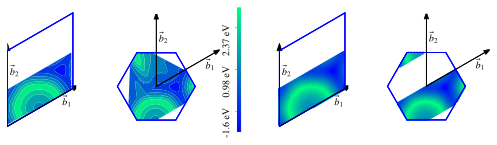

In [ ]:
import matplotlib.pyplot as plt , pivotpy as pp
import matplotlib.tri as tri
axs = pp.init_figure(ncols=5,figsize=(9,2.3),widths=[5,5,0.2,5,5])
evr = pp.export_vasprun('../graphene_example/ISPIN_1/dos/vasprun.xml')
bz1 = get_bz(evr.poscar.basis,primitive=True)
bz2 = get_bz(evr.poscar.basis,primitive=False)
out1 = kpoints2bz(bz1,evr.kpoints,primitive=True)
out2 = kpoints2bz(bz2,evr.kpoints,primitive=False)
splot_bz(bz1,plane='xy',ax = axs[0]).set_axis_off()
splot_bz(bz2,plane='xy',ax = axs[1]).set_axis_off()
splot_bz(bz1,plane='xy',ax = axs[3]).set_axis_off()
splot_bz(bz2,plane='xy',ax = axs[4]).set_axis_off()

# Energy as color on BZ. 
en = evr.bands.evals[:,9].ravel()
s_en = (en-np.min(en))/(np.max(en)-np.min(en)) # bring to range [0,1] for colors
c = plt.cm.get_cmap('winter')(s_en)
labels = [str(l) + ' eV' for l in np.round(np.min(en)+(np.max(en)-np.min(en))*np.array([1/6,3/5,5/6]),2)]
tri1 = tri.Triangulation(out1.T[0], out1.T[1])
tri2 = tri.Triangulation(out2.T[0], out2.T[1])
axs[0].tricontourf(tri1, en, levels=np.linspace(-2.6, 3.4, 8), cmap='winter')
axs[1].tricontourf(tri2, en, levels=np.linspace(-2.6, 3.4, 8), cmap='winter')
axs[3].scatter(out1[:,0],out1[:,1],s=4,c=c)
axs[4].scatter(out2[:,0],out2[:,1],s=4,c=c)

pp.add_colorbar(ax=axs[2],cmap_or_clist='winter', ticklabels=labels,vertical=True)


In [ ]:
#export
class BZ:
    """Brings BZ-related functions together."""
    __doc__ = """{}
    - **Methods**
        - iplot/iplotc : Interactive plot of BZ/Cell. 
        - splot/splotc : Static plot of BZ/Cell.
        - fetch/fetchc : Brings KPOINTS/Positions inside BZ/Cell. 

    """.format('\n'.join(get_bz.__doc__.splitlines()[:7]))
    
    def __init__(self,poscar=None,loop=True, digits=8, primitive=False):
        self.bz = get_bz(poscar=poscar,loop=loop, digits=digits, primitive=primitive)
        self.primitive = primitive
        self.poscar = poscar 

        lat = get_bz(get_bz(poscar,primitive = True).basis, primitive = True) # Double operation
        self.cell = vp.Dict2Data({'basis':lat.basis,'vertices':lat.vertices,'faces':lat.faces})

    def iplot(self,fill=True, color='rgba(168,204,216,0.4)', background='rgb(255,255,255)', fig=None):
        """Returns plotly's Figure of BZ plot."""
        return iplot_bz(self.bz,fill=fill,color=color,background=background,fig=fig)

    def splot(self,ax=None, plane=None, color=(0.4,0.8,0.85), fill=True, vectors=True, v3=False):
        """Returns Matplotlib's Axes of BZ plot."""
        return splot_bz(self.bz,ax=ax,plane=plane,color=color,fill=fill,vectors=vectors,v3=v3)

    def fetch(self,kpoints):
        """Brings KPOINTS inside BZ and returns their R3 coordinates."""
        return kpoints2bz(self.bz, kpoints= kpoints,primitive=self.primitive)

    def iplotc(self,fill=True, color='rgba(168,204,216,0.4)', background='rgb(255,255,255)', fig=None):
        """Returns plotly's Figure of Cell plot."""
        return iplot_bz(self.cell,fill=fill,color=color,background=background,fig=fig,vname='a')

    def splotc(self,ax=None, plane=None, color=(0.4,0.8,0.85), fill=True, vectors=True, v3=False):
        """Returns Matplotlib's Axes of Cell plot."""
        return splot_bz(self.cell,ax=ax,plane=plane,color=color,fill=fill,vectors=vectors,v3=v3,vname='a')

    def fetchc(self,points):
        """Brings atoms's positions inside Cell and returns their R3 coordinates."""
        return to_R3(self.cell.basis, kpoints= points)


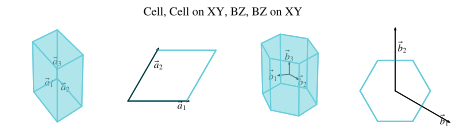

In [ ]:
import matplotlib.pyplot as plt
bz = BZ(hexa,primitive=False)
axs = sp.init_figure(ncols=4,figsize=(8,2))
bz.splotc(ax=axs[0]).set_axis_off()
bz.splotc(ax=axs[1],plane='xy').set_axis_off()
bz.splot(ax=axs[2]).set_axis_off()
bz.splot(ax=axs[3],plane='xy').set_axis_off()
_ = plt.gcf().suptitle('Cell, Cell on XY, BZ, BZ on XY')

In [ ]:
#hide_input
import pivotpy as pp 
pp.nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
